In [1]:
# Standard libraries
import os
from glob import glob

# Basic 3rd party libraries
import pandas as pd
import numpy as np

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# TensorFlow Keras API
from tensorflow.keras.utils import (
    plot_model as tf_plot,
    to_categorical,
)
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
# from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy

# TensorFlow Keras model and layers API
from tensorflow.keras.layers import (
    Input,
    Reshape,
    RepeatVector,
    UpSampling2D,
    Flatten,
    Conv1D,
    Conv2D,
    MaxPooling1D,
    MaxPooling2D,
    LSTM,
    ConvLSTM1D,
    ConvLSTM2D,
    Dense,
    SpatialDropout1D,
    SpatialDropout2D,
    Dropout,
    Concatenate,
)
from tensorflow.keras.models import (
    Sequential,
    Model,
    load_model as tf_load_model,
)



2023-11-07 13:35:12.697828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setting Configs

In [1]:
# Directory storing the CSI and WLAN captures
# resources_dir = "/Volumes/tim_details/tim_honours/CAPTURES"

# Directory to save plots to
plt_dir = "/Users/timothylee/Desktop/Uni/Yr5/Honours/honours_thesis/figures/plt_figs/"

# Supress pd scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Resolution of plots
plt.rcParams["figure.dpi"] = 100 # 300
plt.rcParams["figure.dpi"] = 500 # 300

# Backend to generate plots
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

# plt figure style
fig_style = "seaborn-v0_8-whitegrid"

# colormaps
cmap_qual = "pastel"
cmap_seq = "viridis"
cmap_cycl = "twilight"


## Entire Model

In [2]:
X_csi_shape = (500, 48)
X_wlan_shape = (500, 3)
y_shape = 54


In [11]:
# CSI BRANCH
in_csi = Input(
    shape=X_csi_shape,
    name="input_csi",
)
csi_branch = Sequential(
    [
        Reshape(
            (*in_csi.shape[1:], 1),
            name="reshape_1",
        ),
        Conv2D(
            16, (5, 3), 1, padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling2D(
            2, name="maxpool_1",
        ),
        Conv2D(
            32, (4, 4), 1, padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling2D(
            2, name="maxpool_2",
        ),
        SpatialDropout2D(
            0.5, name="dropout_1"
        ),
        Conv2D(
            16, (3, 5), 1, padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling2D(
            2, name="maxpool_3",
        ),
    ],
    name="CSI_branch",
)(in_csi)

# WLAN BRANCH
in_wlan = Input(
    shape=X_wlan_shape,
    name="input_wlan",
)
wlan_branch = Sequential(
    [
        Conv1D(
            16, (5,), padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling1D(
            2, name="maxpool_1",
        ),
        Conv1D(
            16, (4,), padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling1D(
            2, name="maxpool_2",
        ),
        SpatialDropout1D(
            0.5, name="dropout_1"
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling1D(
            2, name="maxpool_3",
        ),
        Reshape(
            (60, 1, 16),
            name="reshape_1",
        ),
        UpSampling2D(
            (1, 2),
            name="upsample_1",
        ),
    ],
    name="WLAN_branch",
)(in_wlan)

# Merging branches
conc_branches = Concatenate(
    axis=2,
    name="concat",
)([csi_branch, wlan_branch])

# Fully Connected Layers
device_branch = Sequential(
    [   
        Conv2D(
            16, (3, 3), padding="valid", activation="relu", name="conv_1",
        ),
        Flatten(
            name="flatten",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_2"
        ),
        Dense(
            2, activation="softmax", name="output",
        ),
    ],
    name="device_branch",
)(conc_branches)
location_branch = Sequential(
    [   
        Conv2D(
            16, (3, 3), padding="valid", activation="relu", name="conv_1",
        ),
        Flatten(
            name="flatten",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_2"
        ),
        Dense(
            3, activation="softmax", name="output",
        ),
    ],
    name="location_branch",
)(conc_branches)
video_branch = Sequential(
    [   
        Conv2D(
            16, (3, 3), padding="valid", activation="relu", name="conv_1",
        ),
        Flatten(
            name="flatten",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_2"
        ),
        Dense(
            9, activation="softmax", name="output",
        ),
    ],
    name="video_branch",
)(conc_branches)


model = Model(
    inputs=[in_csi, in_wlan],
    outputs=[device_branch, location_branch, video_branch],
    name="XL-NTA",
)

model.summary(expand_nested=True)

Model: "XL-NTA"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_csi (InputLayer)      [(None, 500, 48)]            0         []                            
                                                                                                  
 input_wlan (InputLayer)     [(None, 500, 3)]             0         []                            
                                                                                                  
 CSI_branch (Sequential)     (None, 60, 3, 16)            16176     ['input_csi[0][0]']           
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| reshape_1 (Reshape)        (None, 500, 48, 1)           0         []                           |
|                                                                                            

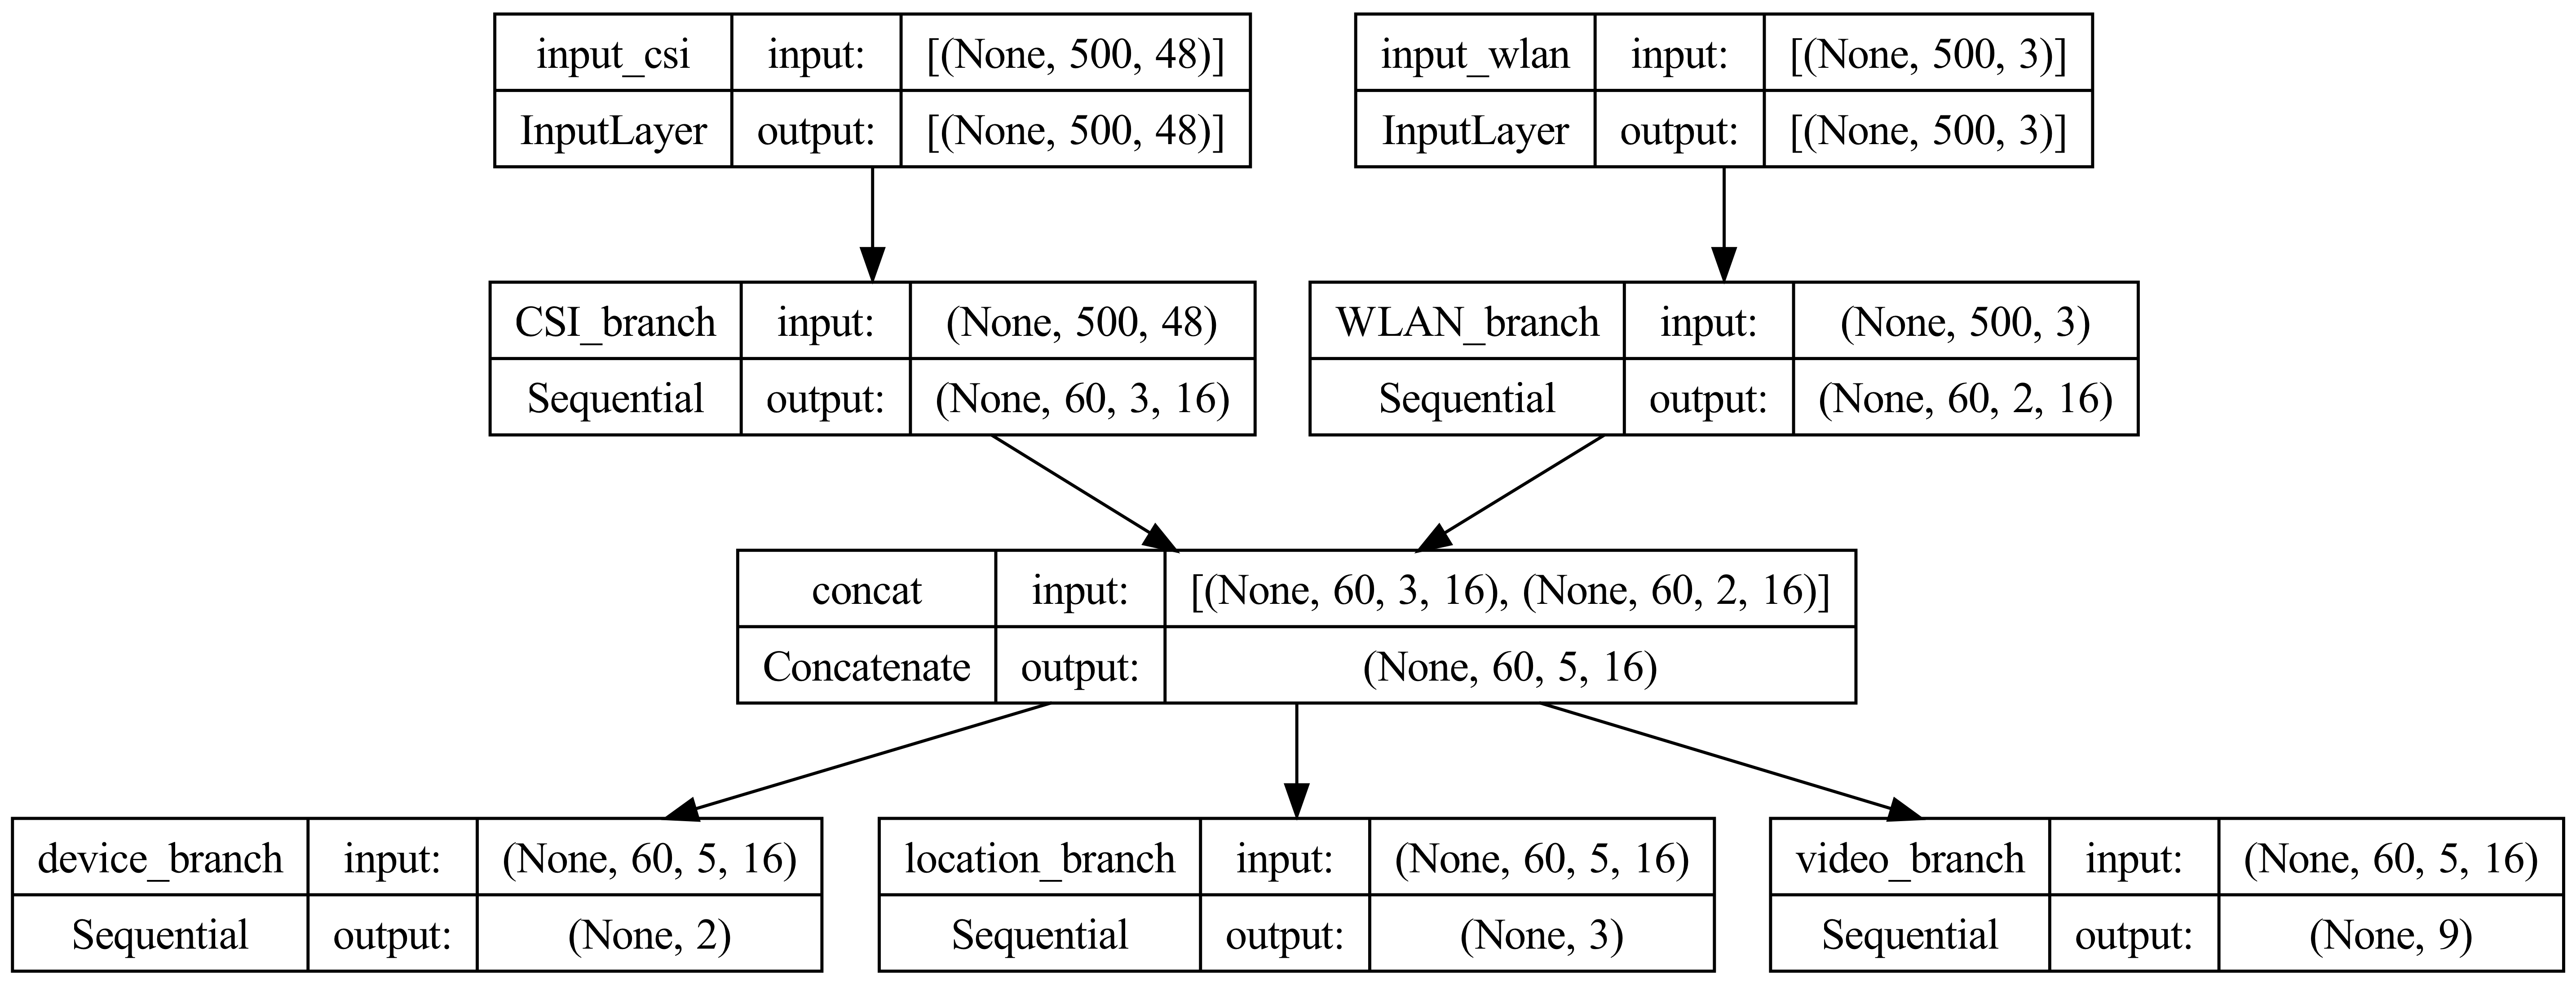

In [12]:
# model.summary(expand_nested=True)

archt_fp = os.path.join(plt_dir, "XL-NTA_architecture.png")
tf_plot(
    model,
    to_file=archt_fp,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB", # LR, TB
    expand_nested=False,
    dpi=500,
    show_layer_activations=True,
    show_trainable=False,
)

In [13]:
archt_fp = os.path.join(plt_dir, "XL-NTA_architecture_expanded.png")
tf_plot(
    model,
    to_file=archt_fp,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB", # LR, TB
    expand_nested=True,
    dpi=500,
    show_layer_activations=True,
    show_trainable=False,
)

## Individual Branches

In [ ]:
# archt_fp = os.path.join(plt_dir, "XL-NTA_architecture.png")
tf_plot(
    Model(
        in_wlan,
        wlan_branch,
    ),
    # to_file=archt_fp,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB", # LR, TB
    expand_nested=True,
    dpi=500,
    show_layer_activations=True,
    show_trainable=False,
)